In [2]:
from skimage.feature import hog
from skimage import color, exposure
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import pickle
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit, train_test_split
from moviepy.editor import *
from scipy.misc import imsave



import time

import glob
from skimage.feature import hog
from scipy.ndimage.measurements import label

%matplotlib inline

### <span style="color:blue">Select test images from video</span>

In [3]:
images = glob.glob('test_images/test*.jpg')
print(images)

['test_images/test1.jpg', 'test_images/test2.jpg', 'test_images/test3.jpg', 'test_images/test4.jpg', 'test_images/test5.jpg', 'test_images/test6.jpg', 'test_images/test7.jpg']


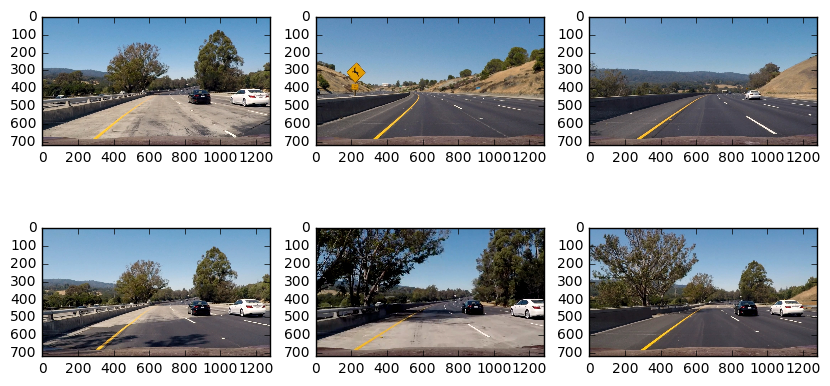

In [4]:
plt.subplots(figsize = (10,5))
i = 0

for i in range(6):
    img = mpimg.imread(images[i])
    img = img.astype(np.float32)/255


#     img = cv2.imread(images[i])
    plt.subplot(231+i), plt.imshow(img)
    i += 1


# 1. Histogram of Oriented Gradients (HOG)


In [5]:
images = glob.glob('Data/*')
cars = []
noncars = []

for image in images:
    if 'Data/car1' in image or 'Data/car2' in image:
        cars.append(glob.glob(image + '/*/*.png'))
    else:
        noncars.append(glob.glob(image + '/*/*.png'))
        
cars = cars[0].copy()
notcars = noncars[0].copy()

In [6]:
print("Total number of car images are %i, total number of not cars is %i" %(len(cars), len(notcars)))

Total number of car images are 8792, total number of not cars is 8968


In [7]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    
    img = cv2.imread(car_list[0])
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


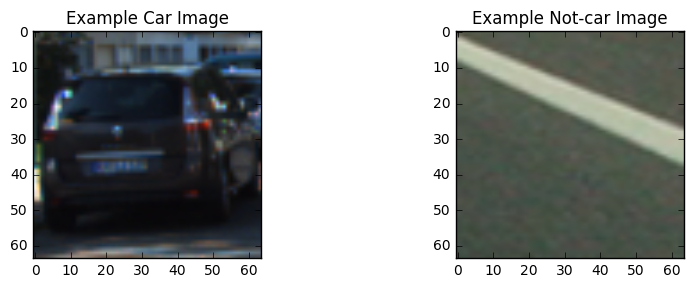

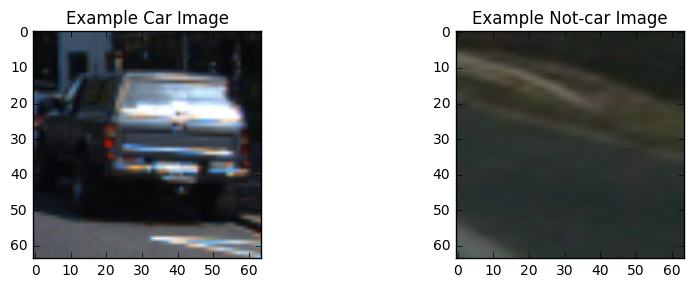

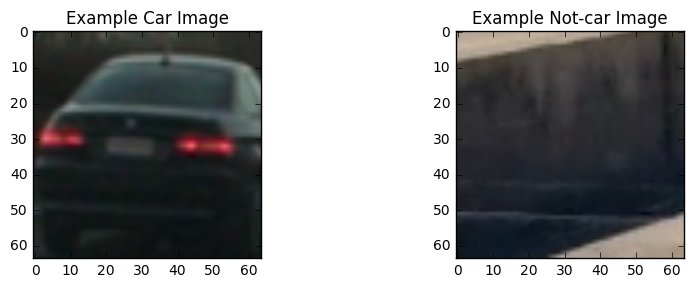

In [8]:
i = 0
# Read in car / not-car images
for img in zip(cars, notcars):
    
    car_ind = np.random.randint(0, len(cars))
    notcar_ind = np.random.randint(0, len(notcars))
    
    car_image = mpimg.imread(cars[car_ind])
    notcar_image = mpimg.imread(notcars[notcar_ind])

    # Plot the examples
    plt.subplots(figsize = (10,10))
    plt.subplot(321+i)
    plt.imshow(car_image)
    plt.title('Example Car Image')
    plt.subplot(321+i+1)
    plt.imshow(notcar_image)
    plt.title('Example Not-car Image')
    
    i += 2
    
    if i > 4:
        break

In [9]:
print(car_image.shape, notcar_image.shape)
print(car_image[:2], notcar_image[:2])

(64, 64, 3) (64, 64, 3)
[[[ 0.21568628  0.21960784  0.19607843]
  [ 0.21568628  0.22745098  0.19607843]
  [ 0.1882353   0.20392157  0.17254902]
  [ 0.17647059  0.2         0.15686275]
  [ 0.17254902  0.19215687  0.14901961]
  [ 0.18039216  0.19215687  0.15294118]
  [ 0.22352941  0.23137255  0.19215687]
  [ 0.25490198  0.26274511  0.22352941]
  [ 0.21568628  0.22352941  0.18431373]
  [ 0.21176471  0.21960784  0.18039216]
  [ 0.20392157  0.21176471  0.17254902]
  [ 0.18039216  0.1882353   0.14901961]
  [ 0.18039216  0.1882353   0.14901961]
  [ 0.20784314  0.21568628  0.18431373]
  [ 0.23137255  0.23529412  0.20784314]
  [ 0.25098041  0.24705882  0.21960784]
  [ 0.22352941  0.21568628  0.19215687]
  [ 0.25882354  0.23529412  0.20784314]
  [ 0.3137255   0.29411766  0.26274511]
  [ 0.33725491  0.34117648  0.3019608 ]
  [ 0.28627452  0.30980393  0.26274511]
  [ 0.25882354  0.28627452  0.23921569]
  [ 0.29411766  0.30980393  0.27058825]
  [ 0.30980393  0.30980393  0.28235295]
  [ 0.3137255   

### <span style="color:blue">Explore Color space and HOG with the example image, Let's use the last image above</span>

In [10]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orient, (pix_per_cell, pix_per_cell), (cell_per_block, cell_per_block), vis)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orient, (pix_per_cell, pix_per_cell), (cell_per_block,cell_per_block), vis)
        return features

# Use the last image above
gray_car = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
gray_notcar = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)


# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features_c, hog_image_c = get_hog_features(gray_car, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
features_nc, hog_image_nc = get_hog_features(gray_notcar, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

In [11]:
def color_hist(img, nbins = 32, bins_range = (0,1)):
    R = np.histogram(img[:,:,0], nbins, bins_range)
    G = np.histogram(img[:,:,1], nbins, bins_range)
    B = np.histogram(img[:,:,2], nbins, bins_range)
    
    bin_edges = R[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((R[0],G[0],B[0]))
    # Return the individual histograms, bin_centers and feature vector
    return R, G, B, bin_centers, hist_features    

R1,G1,B1,center1,hist_vec1 = color_hist(car_image)
R2,G2,B2,center2,hist_vec2 = color_hist(notcar_image)

In [12]:
print(R1)
print(G1)
print(B1)
print(len(hist_vec1))

(array([   0,  447, 1125,  558,  299,  450,  280,  181,  172,  143,   99,
         69,   54,   48,   47,   38,   28,   10,    5,    8,    8,    6,
          4,    4,    2,    6,    0,    0,    4,    0,    1,    0]), array([ 0.     ,  0.03125,  0.0625 ,  0.09375,  0.125  ,  0.15625,
        0.1875 ,  0.21875,  0.25   ,  0.28125,  0.3125 ,  0.34375,
        0.375  ,  0.40625,  0.4375 ,  0.46875,  0.5    ,  0.53125,
        0.5625 ,  0.59375,  0.625  ,  0.65625,  0.6875 ,  0.71875,
        0.75   ,  0.78125,  0.8125 ,  0.84375,  0.875  ,  0.90625,
        0.9375 ,  0.96875,  1.     ]))
(array([   1,    8,  906, 1024,  488,  297,  251,  283,  211,  136,  100,
        110,   60,   58,   49,   30,   48,   27,    8,    1,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0]), array([ 0.     ,  0.03125,  0.0625 ,  0.09375,  0.125  ,  0.15625,
        0.1875 ,  0.21875,  0.25   ,  0.28125,  0.3125 ,  0.34375,
        0.375  ,  0.40625,  0.4375 ,  0.46875,  0.5    ,  0.

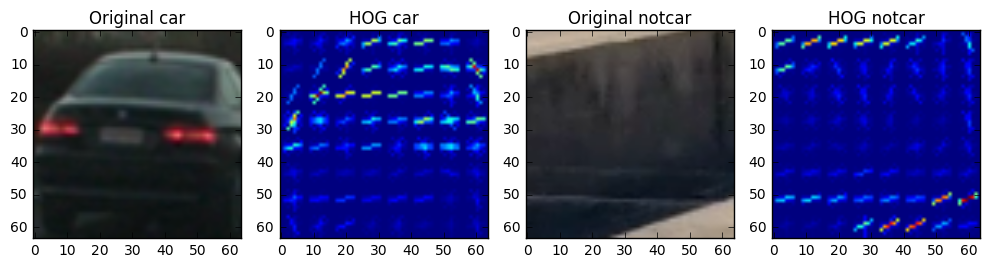

In [13]:
# Plot the examples
plt.subplots(figsize = (10,10))
plt.subplot(141), plt.imshow(car_image), plt.title("Original car")
plt.subplot(142), plt.imshow(hog_image_c), plt.title("HOG car")
plt.subplot(143), plt.imshow(notcar_image), plt.title("Original notcar")
plt.subplot(144), plt.imshow(hog_image_nc), plt.title("HOG notcar")
plt.tight_layout()


(<matplotlib.axes._subplots.AxesSubplot at 0x1204ab7f0>,
 <Container object of 96 artists>)

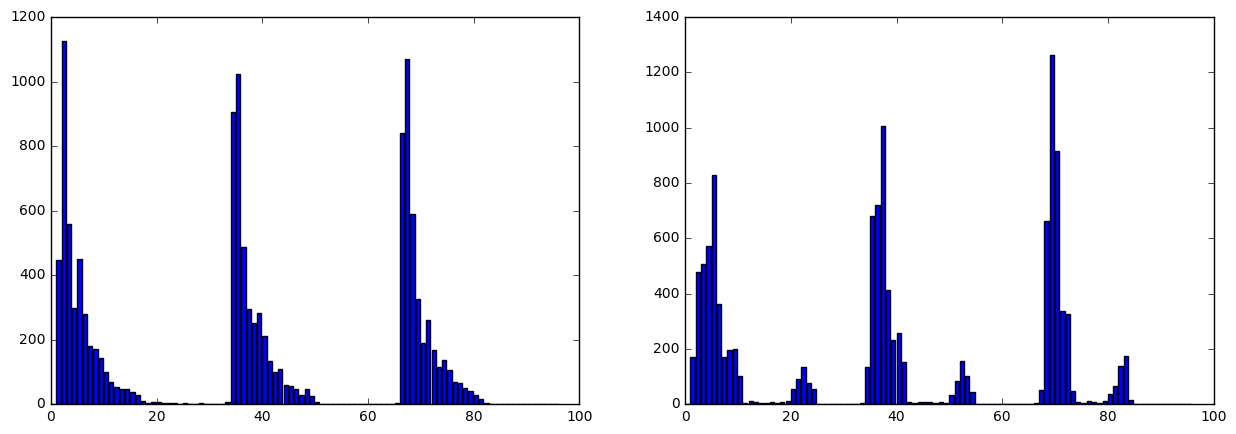

In [14]:
plt.subplots(figsize = (15,5))
plt.subplot(121), plt.bar(range(len(hist_vec1)),hist_vec1)
plt.subplot(122), plt.bar(range(len(hist_vec2)),hist_vec2)

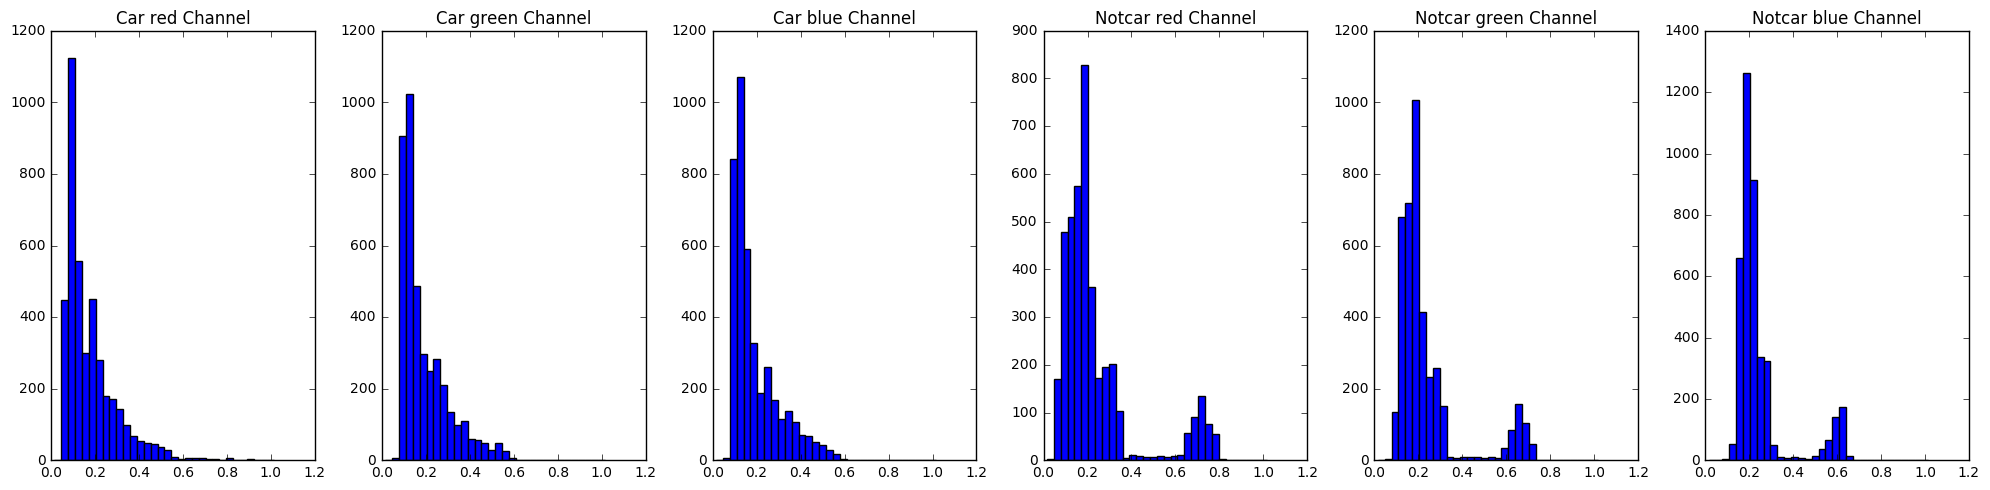

In [15]:
# Plot the examples
plt.subplots(figsize = (20,5))
# hist_features = np.concatenate((R1[0], G1[0], B1[0]))
# hist_features = np.concatenate((R1[0], G1[0], B1[0]))
# hist_features

# plt.subplot(121), plt.bar(np.arange(len(np.concatenate((R1[0], G1[0], B1[0])))),np.concatenate((R1[0], G1[0], B1[0])))

plt.subplot(161), plt.bar(center1, R1[0], width = center1[1]-center1[0]), plt.title("Car red Channel")
plt.subplot(162), plt.bar(center1, G1[0], width = center1[1]-center1[0]), plt.title("Car green Channel")
plt.subplot(163), plt.bar(center1, B1[0], width = center1[1]-center1[0]), plt.title("Car blue Channel")
plt.subplot(164), plt.bar(center2, R2[0], width = center2[1]-center2[0]), plt.title("Notcar red Channel")
plt.subplot(165), plt.bar(center2, G2[0], width = center2[1]-center2[0]), plt.title("Notcar green Channel")
plt.subplot(166), plt.bar(center2, B2[0], width = center2[1]-center2[0]), plt.title("Notcar blue Channel")
plt.tight_layout()


### <span style="color:red">Need to add more Channel images, not now</span>

In [16]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    # Use cv2.resize().ravel() to create the feature vector
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img) 
        
    features = cv2.resize(feature_image, size).ravel()
    # Return the feature vector
    return features


In [17]:
# car_image.shape
# # feature_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2LUV)
# feature_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2LUV)
# # feature_image
# car_image

# images = glob.glob('Data/car1/GTI_Far/*.png')
# car_image = mpimg.imread(images[0])

# images = glob.glob('test_images/test*.jpg')
# car_image = mpimg.imread(images[0])



In [18]:
feature_vec1 = bin_spatial(car_image, color_space='RGB', size=(32, 32))
feature_vec2 = bin_spatial(car_image, color_space='HSV', size=(32, 32))
feature_vec3 = bin_spatial(car_image, color_space='HLS', size=(32, 32))
feature_vec4 = bin_spatial(car_image, color_space='YUV', size=(32, 32))
feature_vec5 = bin_spatial(car_image, color_space='YCrCb', size=(32, 32))

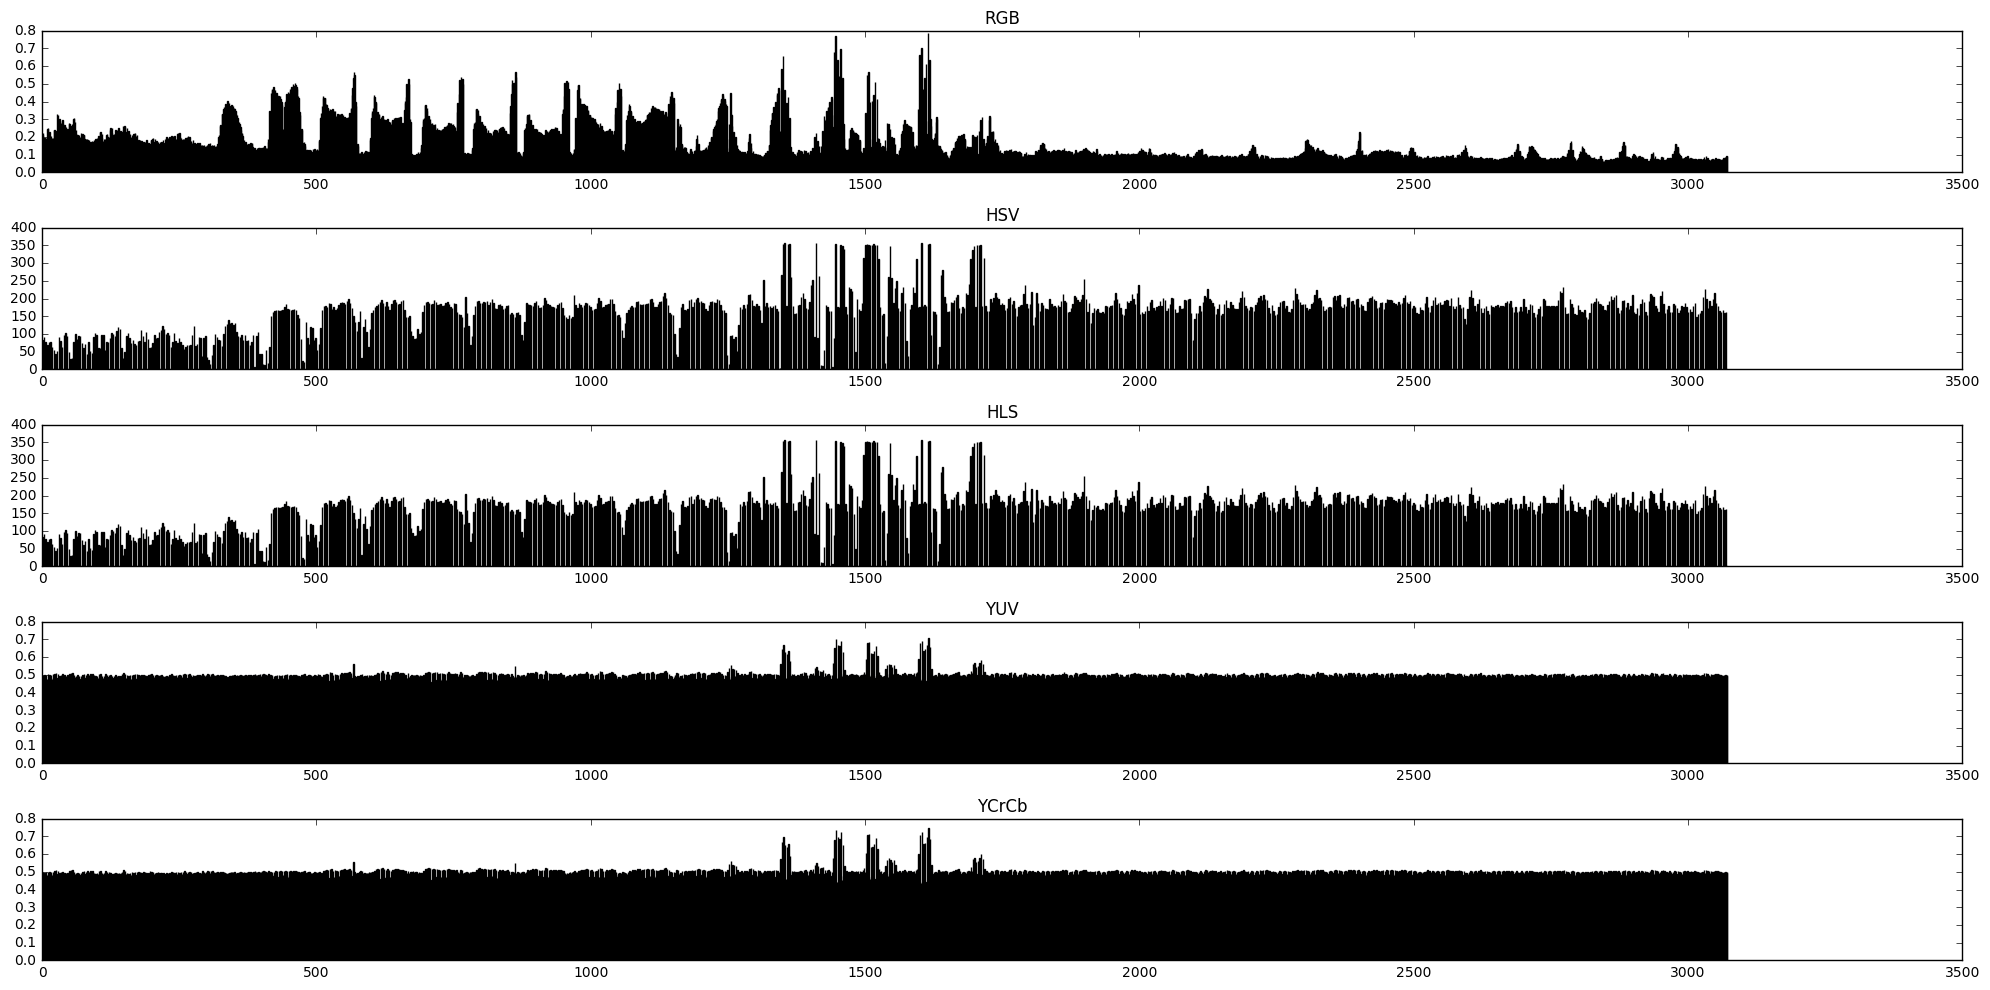

In [19]:
plt.subplots(figsize = (20,10))
plt.subplot(511), plt.bar(range(len(feature_vec1)), feature_vec1), plt.title("RGB")
plt.subplot(512), plt.bar(range(len(feature_vec2)), feature_vec2), plt.title("HSV")
plt.subplot(513), plt.bar(range(len(feature_vec3)), feature_vec3), plt.title("HLS")
plt.subplot(514), plt.bar(range(len(feature_vec4)), feature_vec4), plt.title("YUV")
plt.subplot(515), plt.bar(range(len(feature_vec5)), feature_vec5), plt.title("YCrCb")
plt.tight_layout()

# 2. Sliding window Search
#### with the test images on the top

In [20]:
images = glob.glob('test_images/test*.jpg')

img = mpimg.imread(images[0])
# print(img)
img = img.astype(np.float32)/255
# print(img[:1])

# img = cv2.imread(images[0])
# print(img[:1])


# plt.imshow(img)

In [21]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=3):
    # make a copy of the image
    draw_img = np.copy(img)
    cv2.rectangle(draw_img, bboxes[0], bboxes[1], color, thick)
    return draw_img


def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_min=(None,None), xy_max=(None,None), xy_step = None, xy_overlap=(0.5, 0.5)):
    i = 0
    xy_list = []
    
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]


    for idx in range(xy_step):
        xy_list.append((xy_min[0]+int((xy_max[0]-xy_min[0])*(idx+1)/xy_step),xy_min[1]+int((xy_max[1]-xy_min[1])*(idx+1)/xy_step)))
        
    # Initialize a list to append window positions to
    window_list = []
        
    for xy_window in xy_list:
#         print(xy_window[0], xy_window[1])
        # If x and/or y start/stop positions not defined, set to image size
        # Compute the span of the region to be searched
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]

        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 

        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        
#         for win in window_list:
#             img = draw_boxes(img, win, color=(0, 0, 255), thick=3)                    
# #             plt.imshow(img)
#         plt.subplots(figsize = (10,10))
#         plt.subplot(151+i), plt.imshow(img)
#         img = cv2.imread(images[i])
#         window_list = []

#         i = i + 1
    return window_list

windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[350, None], 
                    xy_min=(16, 16), xy_max=(128,128), xy_step = 3, xy_overlap=(0.5, 0.5))

### Multi scale window search along the lane

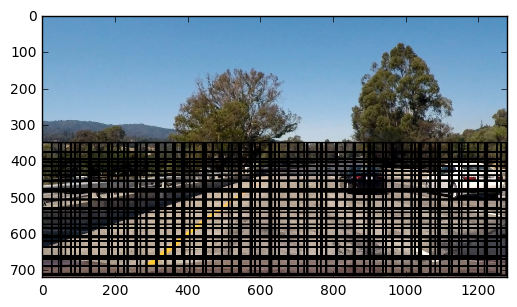

In [22]:
for win in windows:
    img = draw_boxes(img, win, color=(0, 0, 255), thick=3)                    
    plt.imshow(img)

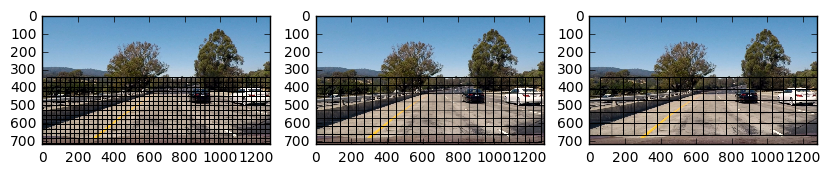

In [23]:
xy_min = 64
i = 0
plt.subplots(figsize = (10,10))


for win in windows:
    if (win[1][0] - win[0][0]) != xy_min:
        xy_min = win[1][0] - win[0][0]
        i = i+1
        img = mpimg.imread(images[0])
        img = img.astype(np.float32)/255


#         img = cv2.imread(images[0])
    else:
        img = draw_boxes(img, win, color=(0, 0, 255), thick=3)    
        plt.subplot(130+i), plt.imshow(img)       

# 3. Optimize the performance

In [24]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# # Define a function to compute binned color features  

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
#     # Use cv2.resize().ravel() to create the feature vector
#     features = cv2.resize(img, size).ravel() 
#     # Return the feature vector
#     return features

    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    
    return np.hstack((color1, color2, color3))
     
    
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [25]:
# mpimg.imread('/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Vehicle-Detection P5/Submit2/Data/car1/KITTI_extracted/1.png')

In [26]:
# feature -> def bin_spatial(img, color_space='RGB', size=(32, 32)):

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!

# R,G,B,center, vector -> def color_hist(img, nbins = 32, bins_range = (0,255)):


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):

    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
#             print(spatial_features.shape)
            
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
#             print(hist_features.shape)
            
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)  
                
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
            # Append the new feature vector to the features list
            file_features.append(hog_features)
#             print(hog_features.shape)
            
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=3):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [27]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    

    #1) Define an empty list to receive features
    img_features = []
    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)  
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
        
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
        
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [28]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
#         print(features.shape)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
#         print(test_features.shape)
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
#         prob = clf.predict_proba(test_features)

        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
#             y_proba = clf.predict_proba(test_features)
#             print(prediction, y_proba)


    #8) Return windows for positive detections
    return on_windows
     

## Parameter optimization

In [30]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
# sample_size = 2000
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]
print(len(cars), len(notcars))


### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# print(car_features[:5], notcar_features[:5])
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(
#     scaled_X, y, test_size=0.3, random_state=30)

SFS = StratifiedShuffleSplit(test_size = 0.3, random_state = 100)

for train_index, test_index in SFS.split(scaled_X, y):
    X_train, X_test = scaled_X[train_index], scaled_X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a Linear SVC 
# clf = SVC(kernel = 'rbf', probability = True)
clf = LinearSVC()

# clf = CalibratedClassifierCV(svm)
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

8792 8968
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932
14.91 Seconds to train SVC...
Test Accuracy of SVC =  0.9818


In [31]:
images[0]

'test_images/test1.jpg'

In [32]:
image = mpimg.imread(images[0])
image = image.astype(np.float32)/255


# print(image)
draw_image = np.copy(image)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, None], 
                    xy_min=(16, 16), xy_max=(128,128), xy_step = 3, xy_overlap=(0.5, 0.5))
# print(windows)
hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

# box_centroid = []
# for idx in np.arange(len(hot_windows)):
#     box_centroid.append(np.mean(hot_windows[idx], axis = 0))

# window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=3)                    

# plt.imshow(window_img)

In [33]:
# len(box_centroid)

# HEATMAP function

In [34]:
# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        heatmap[0:720,0:400] = 0
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (150,50,0), 6)
    # Return the image
    return img


## Single image processing test

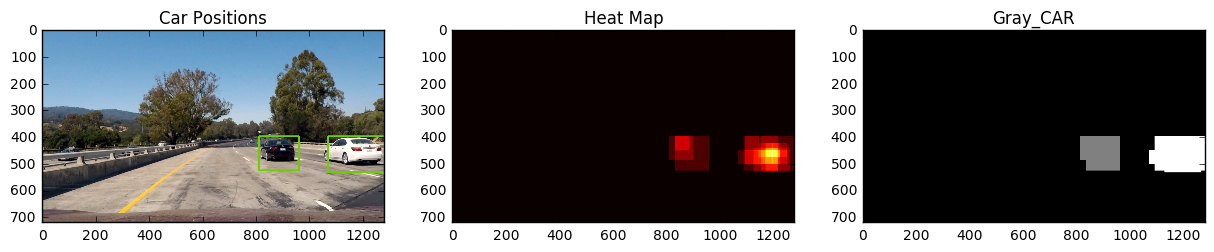

In [35]:
# draw_image = np.copy(image)

# windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, None], 
#                     xy_min=(32, 32), xy_max=(128,128), xy_step = 3, xy_overlap=(0.5, 0.5))

# hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)                       
# print(hot_windows)
# # window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=3)                    
image = mpimg.imread(images[0])
image = image.astype(np.float32)/255


heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat, hot_windows)

# plt.imshow(heat)


# Apply threshold to help remove false positives
heat = apply_threshold(heat, 0)


# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img1 = draw_labeled_bboxes(np.copy(image), labels)

# import scipy.misc
# scipy.misc.imsave('example.png', draw_img1)

# labels

fig = plt.figure()
plt.subplots(figsize = (15,15))
plt.subplot(131)
plt.imshow(draw_img1)
plt.title('Car Positions')
plt.subplot(132)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(133)
plt.imshow(labels[0], cmap='gray')
plt.title('Gray_CAR')

## Multiple image processing test

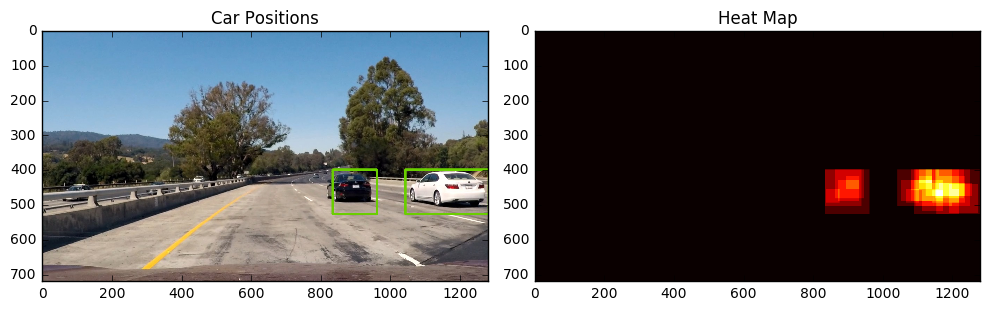

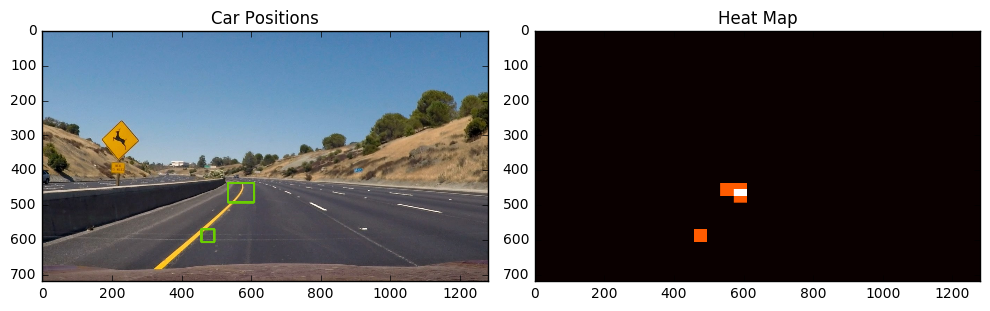

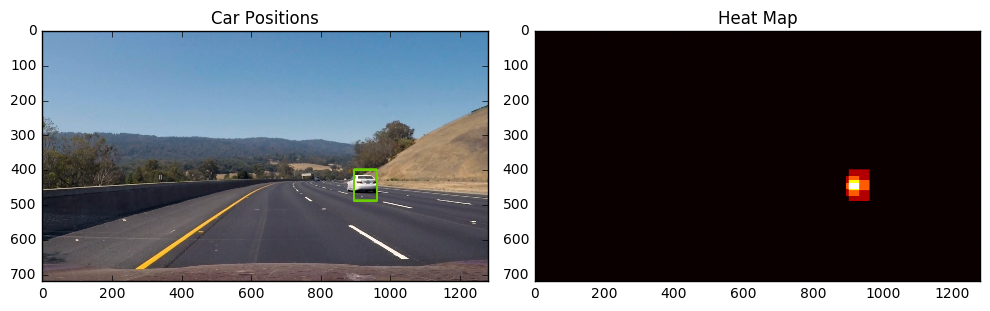

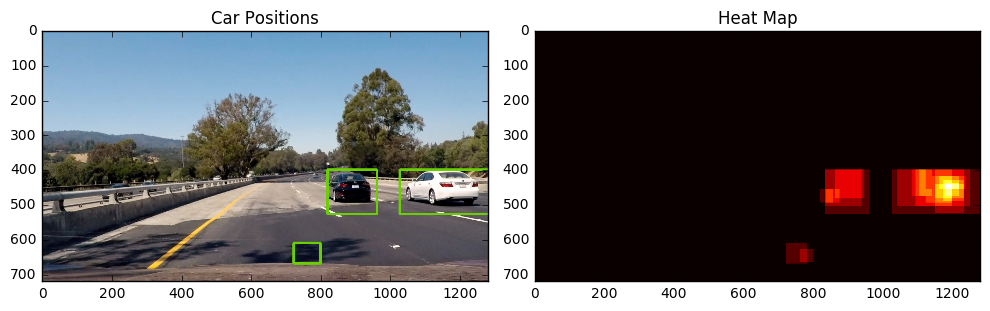

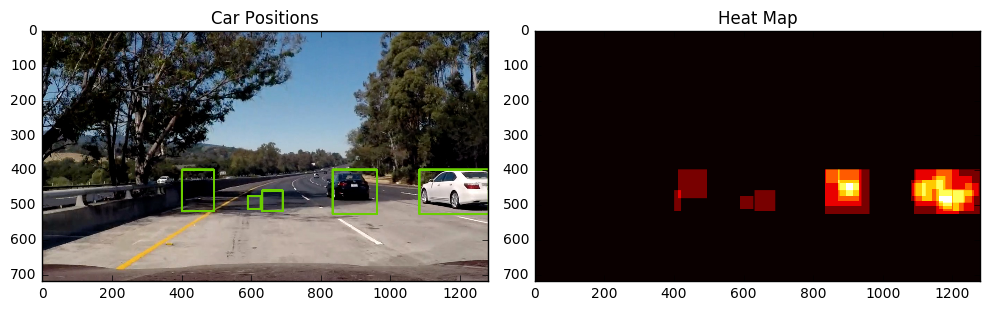

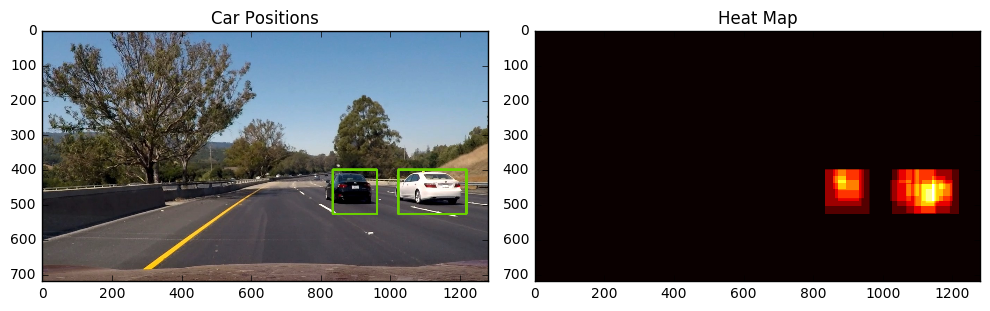

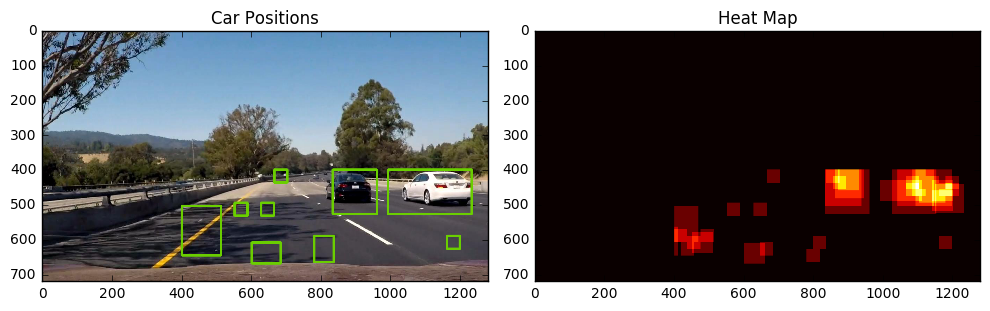

In [36]:
i = 0

ex = glob.glob('test_images/test*.jpg')

for idx in ex:
    img = mpimg.imread(idx)
    img = img.astype(np.float32)/255
  
    draw_image = np.copy(img)
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, None], 
                    xy_min=(16, 16), xy_max=(128,128), xy_step = 5, xy_overlap=(0.5, 0.5))
   
    hot_windows = search_windows(img, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 0)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

#     fig = plt.figure

    plt.subplots(figsize = (10,10))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heat, cmap='hot')
    plt.title('Heat Map')
    plt.tight_layout()
    
    i = i + 2

## Car searching Function for video processing

In [37]:
color_space

'YCrCb'

In [38]:
def process_image(img):

    draw_image = np.copy(img)
    draw_image = draw_image.astype(np.float32)/255
#     print(img, draw_image)

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, None], 
                    xy_min=(16, 16), xy_max=(128,128), xy_step = 3, xy_overlap=(0.5, 0.5))


    hot_windows = search_windows(draw_image, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       


    heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)


    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 0)


    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)


    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img


## VIDEO PROCESSING

In [39]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [40]:
white_output = 'project_result.mp4'
path = '/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Vehicle-Detection P5/Submit2'
clip1 = VideoFileClip(path + "/Untitled.mp4")

In [41]:
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_result.mp4
[MoviePy] Writing video project_result.mp4


  1%|▏         | 2/139 [00:02<03:22,  1.48s/it]

KeyboardInterrupt: 

# Solution2. Image processing

## Read original image and extract frame by frame

In [103]:
cpt = 0
maxFrames = 1600 # if you want 5 frames only.

cap = cv2.VideoCapture(path + "/project_video.mp4")

while cpt < maxFrames:
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    imsave('result/frame%d.jpg' %cpt, frame)
    
    cpt += 1
    

error: /Users/jenkins/miniconda/1/x64/conda-bld/work/opencv-3.1.0/modules/imgproc/src/color.cpp:7341: error: (-215) scn == 3 || scn == 4 in function ipp_cvtColor


In [42]:

# cpt = 0
# maxFrames = 1 # if you want 5 frames only.

# cap = cv2.VideoCapture(path + "/Untitled.mp4")

# while cpt < maxFrames:
#     ret, frame = cap.read() # read frame and return code.
#     frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     frame = frame.astype(np.float32)/255

#     if not ret: # if return code is bad, abort.
#         sys.exit(0)

#     draw_image = np.copy(frame)
    
#     windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[400, None], 
#                     xy_min=(16, 16), xy_max=(128,128), xy_step = 3, xy_overlap=(0.5, 0.5))

#     hot_windows = search_windows(draw_image, windows, clf, X_scaler, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)                       

#     heat = np.zeros_like(draw_image[:,:,0]).astype(np.float)

#     # Add heat to each box in box list
#     heat = add_heat(heat, hot_windows)

#     # Apply threshold to help remove false positives
#     heat = apply_threshold(heat, 0)

#     # Visualize the heatmap when displaying    
#     heatmap = np.clip(heat, 0, 255)

#     # Find final boxes from heatmap using label function
#     labels = label(heatmap)
#     draw_img = draw_labeled_bboxes(np.copy(frame), labels)
#     plt.imshow(draw_img)
# #     imsave('result/frame%d.png' %cpt, heatmap)

#     cpt += 1

### Image folder list in order sequentially

In [43]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split('(\d+)', text) ]

alist = glob.glob('result/*')

alist.sort(key=natural_keys)

# Replace the original image to vehicle detection image

In [49]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars

    box_centroid = []
    
    for car_number in range(1,labels[1]+1):
        # Find pixels with each car_number label value
#         print(car_number)
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (150,50,0), 6)
#         for idx in np.arange(len(draw_img)):
        
        box_centroid.append(np.mean(bbox, axis = 0))

#         print(box_centroid, car_number)
    # Return the image
    return img

# ex = glob.glob('result/*')
tmp = np.zeros(img[:,:,0].shape)
tmp_labels = (np.zeros(img[:,:,0].shape),0)

cnt = 1
cpt = 0
tmp_list = []


for idx in alist:
    img = mpimg.imread(idx)
    img = img.astype(np.float32)/255
    draw_image = np.copy(img)
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, None], 
                    xy_min=(16, 16), xy_max=(128,128), xy_step = 3, xy_overlap=(0.5, 0.5))
   
    hot_windows = search_windows(img, windows, clf, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    tmp_list.append(heat)
    
    if len(tmp_list) == 5:
        for val in tmp_list:
            tmp = val + tmp
            
        tmp_list.pop(0)
        
        heat = apply_threshold(tmp/2, 3.0)
        tmp = np.zeros(img[:,:,0].shape)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        
        if labels[1] > 0:
            tmp_labels = labels
        else:
            labels = tmp_labels
        
#         print(labels[1])
        
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
#         print("IF")
    else:
        heat = apply_threshold(heat, 5)
        
        heatmap = np.clip(heat, 0, 255)

        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        
        if labels[1] > 0:
            tmp_labels = labels
                
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
#         print("ELSE")
    
    mpimg.imsave("result2/%04d.png" %cnt, draw_img)   
    cnt += 1
    
#     plt.subplot(132)
#     plt.imshow(labels[0])
#     plt.title('label Map')
#     plt.subplot(133)
#     plt.imshow(draw_img)
#     plt.title('Final image')
#     plt.tight_layout()

In [51]:
import os
path = '/Users/JAY/Desktop/Udacity/Self_Driving_Car/CarND-Vehicle-Detection P5/Submit2/result2'
files = os.listdir(path)
i = 1

for file in files:
    os.rename(os.path.join(path, file), os.path.join(path, '%04d.png' %i))
    i = i+1